# Stock Price Forecasting with ONNX

## Introduction

This notebook demonstrates a complete end-to-end stock price forecasting system using deep learning and ONNX for production deployment. The implementation showcases:

- **End-to-end workflow** from raw stock data to production-ready models
- **LSTM architecture** for sequential pattern learning in financial time series
- **ONNX conversion** for optimized inference (2-5x speedup over TensorFlow)
- **Percentage-based prediction** strategy for better generalization across price ranges
- **Comprehensive evaluation** framework with multiple metrics

### Key Design Decisions

**Why predict percentage changes instead of absolute prices?**

The system predicts percentage changes (e.g., +2.5% or -1.3%) rather than absolute prices because:
- **Scale invariance**: Works across different price levels without retraining
- **Better stationarity**: Percentage changes are more stationary than absolute prices
- **Trading relevance**: Returns matter more than absolute price levels
- **Cross-stock generalization**: Same model can potentially forecast different stocks

**Why use ONNX for deployment?**

ONNX (Open Neural Network Exchange) provides:
- **Performance**: 2-5x faster inference compared to TensorFlow/Keras
- **Portability**: Deploy across different platforms and runtimes
- **Production-ready**: Optimized operators and memory management
- **Framework agnostic**: Convert from TensorFlow, PyTorch, or scikit-learn

---

## Cell 1: Import Required Libraries

Import all necessary libraries and utility functions. The `onnx_forecasting_utils` module provides modular functions for:
- Data loading and preprocessing
- Feature engineering (technical indicators)
- Model building and training
- ONNX conversion and inference
- Evaluation and visualization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from onnx_forecasting_utils import (
    load_stock_data, parse_and_sort_dates, handle_missing_values,
    detect_and_handle_outliers, split_data_chronological, normalize_data,
    calculate_moving_averages, calculate_bollinger_bands, calculate_atr,
    calculate_rsi, calculate_macd, calculate_volume_indicators,
    apply_all_features, create_rolling_windows,
    LSTMConfig, build_lstm_model, compile_model, create_and_train_lstm,
    convert_to_onnx, verify_onnx, ONNXInferenceSession,
    compare_frameworks_inference,
    evaluate_forecasts, plot_predictions_vs_actual, plot_residuals,
    create_forecast_report, compare_models
)

sns.set_style('whitegrid')
print("All libraries imported successfully!")

2025-12-11 15:04:33.197035: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765465473.216732      13 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765465473.222865      13 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765465473.251741      13 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765465473.251764      13 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765465473.251766      13 computation_placer.cc:177] computation placer alr

All libraries imported successfully!


---

## Cell 2: Load and Explore Stock Data

### Data Source and Characteristics

We load historical Google (GOOG) stock data in CSV format containing:
- **OHLCV Data**: Open, High, Low, Close prices, and trading Volume
- **Daily Granularity**: One record per trading day
- **Multi-year History**: Sufficient data for training deep learning models

### Why Exploratory Data Analysis Matters

Before training any model, we must understand:
- **Date range and completeness**: Any gaps or missing periods?
- **Price trends**: Bull markets, bear markets, or consolidation?
- **Volume patterns**: Normal trading activity vs exceptional spikes?
- **Statistical properties**: Mean, variance, outliers, and distribution shape

This analysis informs preprocessing decisions and helps set realistic performance expectations.

In [2]:
data_path = 'data/Stocks/goog.us.txt'
df = load_stock_data(data_path, date_column='Date')

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"\nFirst few rows:")
print(df.head())

print(f"\nDataset info:")
print(df.info())

print(f"\nMissing values:")
print(df.isnull().sum())

Dataset shape: (916, 7)
Date range: 2014-03-27 00:00:00 to 2017-11-10 00:00:00

First few rows:
        Date    Open    High     Low   Close  Volume  OpenInt
0 2014-03-27  568.00  568.00  552.92  558.46   13052        0
1 2014-03-28  561.20  566.43  558.67  559.99   41003        0
2 2014-03-31  566.89  567.00  556.93  556.97   10772        0
3 2014-04-01  558.71  568.45  558.71  567.16    7932        0
4 2014-04-02  599.99  604.83  562.19  567.00  146697        0

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916 entries, 0 to 915
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     916 non-null    datetime64[ns]
 1   Open     916 non-null    float64       
 2   High     916 non-null    float64       
 3   Low      916 non-null    float64       
 4   Close    916 non-null    float64       
 5   Volume   916 non-null    int64         
 6   OpenInt  916 non-null    int64         
dtypes: 

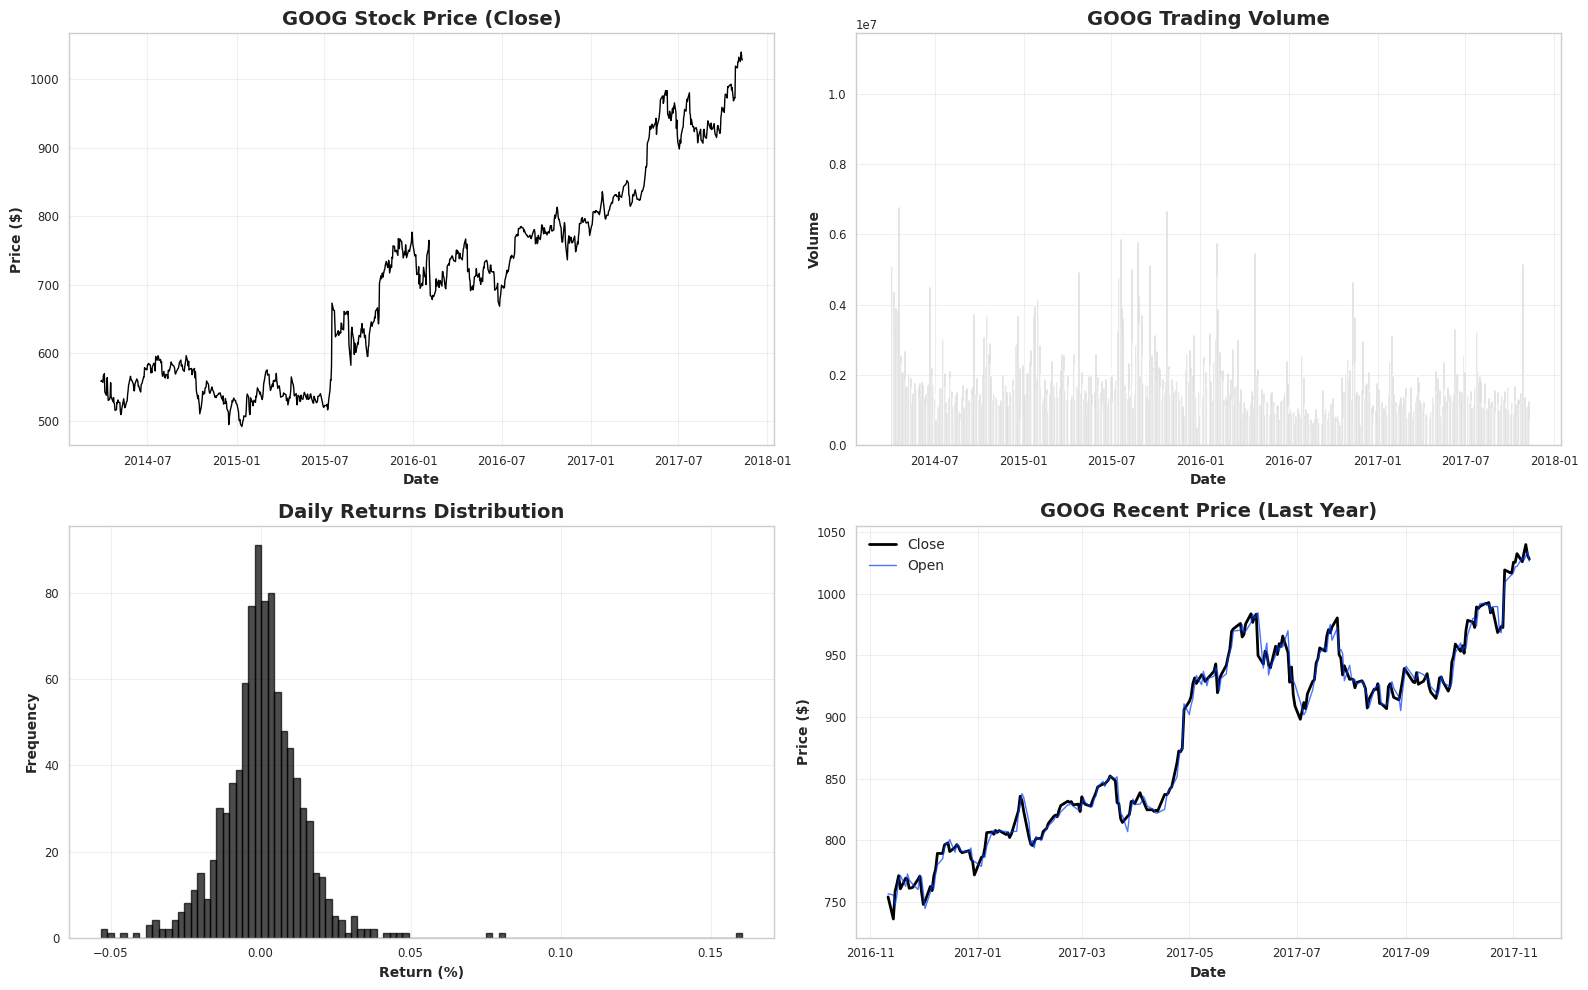


Basic Statistics:
              Open         High          Low        Close        Volume
count   916.000000   916.000000   916.000000   916.000000  9.160000e+02
mean    702.895757   708.114831   697.058311   702.812259  1.725988e+06
std     144.142510   144.697658   143.888208   144.496999  9.540722e+05
min     494.650000   495.980000   487.560000   492.550000  7.932000e+03
25%     560.525000   565.097500   555.627500   559.792500  1.173610e+06
50%     710.780000   718.380000   703.450000   711.005000  1.511322e+06
75%     793.825000   798.057500   787.887750   794.257500  1.988164e+06
max    1033.990000  1048.390000  1028.450000  1039.850000  1.116490e+07


In [3]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

axes[0, 0].plot(df['Date'], df['Close'], linewidth=1)
axes[0, 0].set_title('GOOG Stock Price (Close)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Price ($)')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].bar(df['Date'], df['Volume'], width=1, alpha=0.7)
axes[0, 1].set_title('GOOG Trading Volume', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Volume')
axes[0, 1].grid(True, alpha=0.3)

price_changes = df['Close'].pct_change()
axes[1, 0].hist(price_changes.dropna(), bins=100, edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Daily Returns Distribution', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Return (%)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(True, alpha=0.3)

recent_df = df.tail(252)
axes[1, 1].plot(recent_df['Date'], recent_df['Close'], label='Close', linewidth=2)
axes[1, 1].plot(recent_df['Date'], recent_df['Open'], label='Open', linewidth=1, alpha=0.7)
axes[1, 1].set_title('GOOG Recent Price (Last Year)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Price ($)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nBasic Statistics:")
print(df[['Open', 'High', 'Low', 'Close', 'Volume']].describe())

---

## Cell 4: Data Preprocessing

### Data Validation and Cleaning Strategy

Time series data requires careful preprocessing to ensure quality and temporal consistency.

#### Date Parsing and Sorting
Ensures chronological order, which is critical for time series analysis. Any out-of-order records could corrupt sequential models.

#### Missing Value Handling
**Forward Fill Strategy**: Propagates the last known price forward, appropriate for stock data where prices carry forward during non-trading periods (weekends, holidays).

Why not interpolation? Linear interpolation would create artificial price points between trading days, which doesn't reflect market reality. Forward fill preserves the last known market price.

#### Outlier Detection and Handling
**IQR (Interquartile Range) Method**: Identifies extreme price movements using statistical quartiles.
- Outliers beyond 1.5× IQR are detected
- Values are capped rather than removed to preserve temporal continuity
- This handles flash crashes or data errors without creating gaps in the time series

**Critical Design Decision**: We cap outliers instead of removing them because removing creates gaps that break sequential modeling. Capping preserves the timeline while limiting extreme values' impact.

In [4]:
df = parse_and_sort_dates(df, date_column='Date')
df = handle_missing_values(df, method='forward_fill')

price_cols = ['Open', 'High', 'Low', 'Close']
df = detect_and_handle_outliers(df, columns=price_cols, method='iqr', threshold=1.5)

print("Data preprocessing complete")
print(f"Cleaned dataset shape: {df.shape}")
print(f"Missing values after preprocessing: {df.isnull().sum().sum()}")

Data preprocessing complete
Cleaned dataset shape: (916, 7)
Missing values after preprocessing: 0


---

## Cell 5: Feature Engineering - Technical Indicators

### Technical Indicators Strategy

We calculate technical indicators that professional traders use for market analysis. These indicators transform raw price data into features that capture market dynamics.

#### Trend Indicators
- **SMA (Simple Moving Average)**: Equally weighted average over windows (5, 10, 20, 50 days)
- **EMA (Exponential Moving Average)**: Gives more weight to recent prices, responds faster to changes
- **Crossovers**: When short-term average crosses long-term, signals trend reversals

#### Volatility Indicators
- **Bollinger Bands**: Measure price volatility using standard deviations around a moving average
  - Upper/Lower bands expand during high volatility
  - Band width itself indicates volatility regime
- **ATR (Average True Range)**: Quantifies price volatility magnitude, normalized across price levels

#### Momentum Indicators
- **RSI (Relative Strength Index)**: Measures momentum by comparing upward vs downward movements
  - Values > 70 indicate overbought conditions
  - Values < 30 indicate oversold conditions
  - Mean-reversion signal for potential reversals
- **MACD**: Tracks relationship between two exponential moving averages
  - MACD line, signal line, and histogram capture momentum shifts

#### Volume Indicators
- **Volume Ratio**: Compares current volume to average, highlights abnormal trading activity
- **OBV (On-Balance Volume)**: Accumulates volume based on price direction, shows if volume supports price movements

### Target Variable: Percentage Change

**Key Design Choice**: The model predicts percentage change rather than absolute prices.

```
Target = (Price_t - Price_t-1) / Price_t-1
```

For example: 0.02 = 2% increase, -0.01 = 1% decrease

**Why Percentage Changes?**
1. **Scale Invariance**: Works across different price levels without retraining
2. **Stationarity**: More stationary than absolute prices (better for model convergence)
3. **Trading Relevance**: Returns matter more than absolute price levels
4. **Generalization**: Same model can potentially forecast different stocks

In [5]:
print("Calculating technical indicators...")

df = calculate_moving_averages(df, price_column='Close', windows=[5, 10, 20, 50])
df = calculate_bollinger_bands(df, price_column='Close', window=20, num_std=2.0)
df = calculate_atr(df, high_col='High', low_col='Low', close_col='Close', window=14)
df = calculate_rsi(df, price_column='Close', window=14)
df = calculate_macd(df, price_column='Close', fast_period=12, slow_period=26, signal_period=9)
df = calculate_volume_indicators(df, volume_column='Volume', price_column='Close')

# Calculate percentage change (target variable)
# Model will output 0.1 for 10% change, -0.05 for -5% change, etc.
df['Price_Change_Pct'] = df['Close'].pct_change()

df = df.dropna()

print(f"Technical indicators calculated")
print(f"Dataset shape after feature engineering: {df.shape}")
print(f"\nAvailable features:")
print(df.columns.tolist())
print(f"\nTarget variable statistics (Price_Change_Pct):")
print(f"  Mean: {df['Price_Change_Pct'].mean():.6f} ({df['Price_Change_Pct'].mean()*100:.4f}%)")
print(f"  Std:  {df['Price_Change_Pct'].std():.6f} ({df['Price_Change_Pct'].std()*100:.4f}%)")
print(f"  Min:  {df['Price_Change_Pct'].min():.6f} ({df['Price_Change_Pct'].min()*100:.4f}%)")
print(f"  Max:  {df['Price_Change_Pct'].max():.6f} ({df['Price_Change_Pct'].max()*100:.4f}%)")

Calculating technical indicators...
Technical indicators calculated
Dataset shape after feature engineering: (867, 28)

Available features:
['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt', 'SMA_5', 'EMA_5', 'SMA_10', 'EMA_10', 'SMA_20', 'EMA_20', 'SMA_50', 'EMA_50', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'BB_Width', 'ATR', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Histogram', 'Volume_SMA_20', 'Volume_Ratio', 'OBV', 'Price_Change_Pct']

Target variable statistics (Price_Change_Pct):
  Mean: 0.000809 (0.0809%)
  Std:  0.013909 (1.3909%)
  Min:  -0.053179 (-5.3179%)
  Max:  0.160524 (16.0524%)


---

## Cell 6: Visualize Technical Indicators

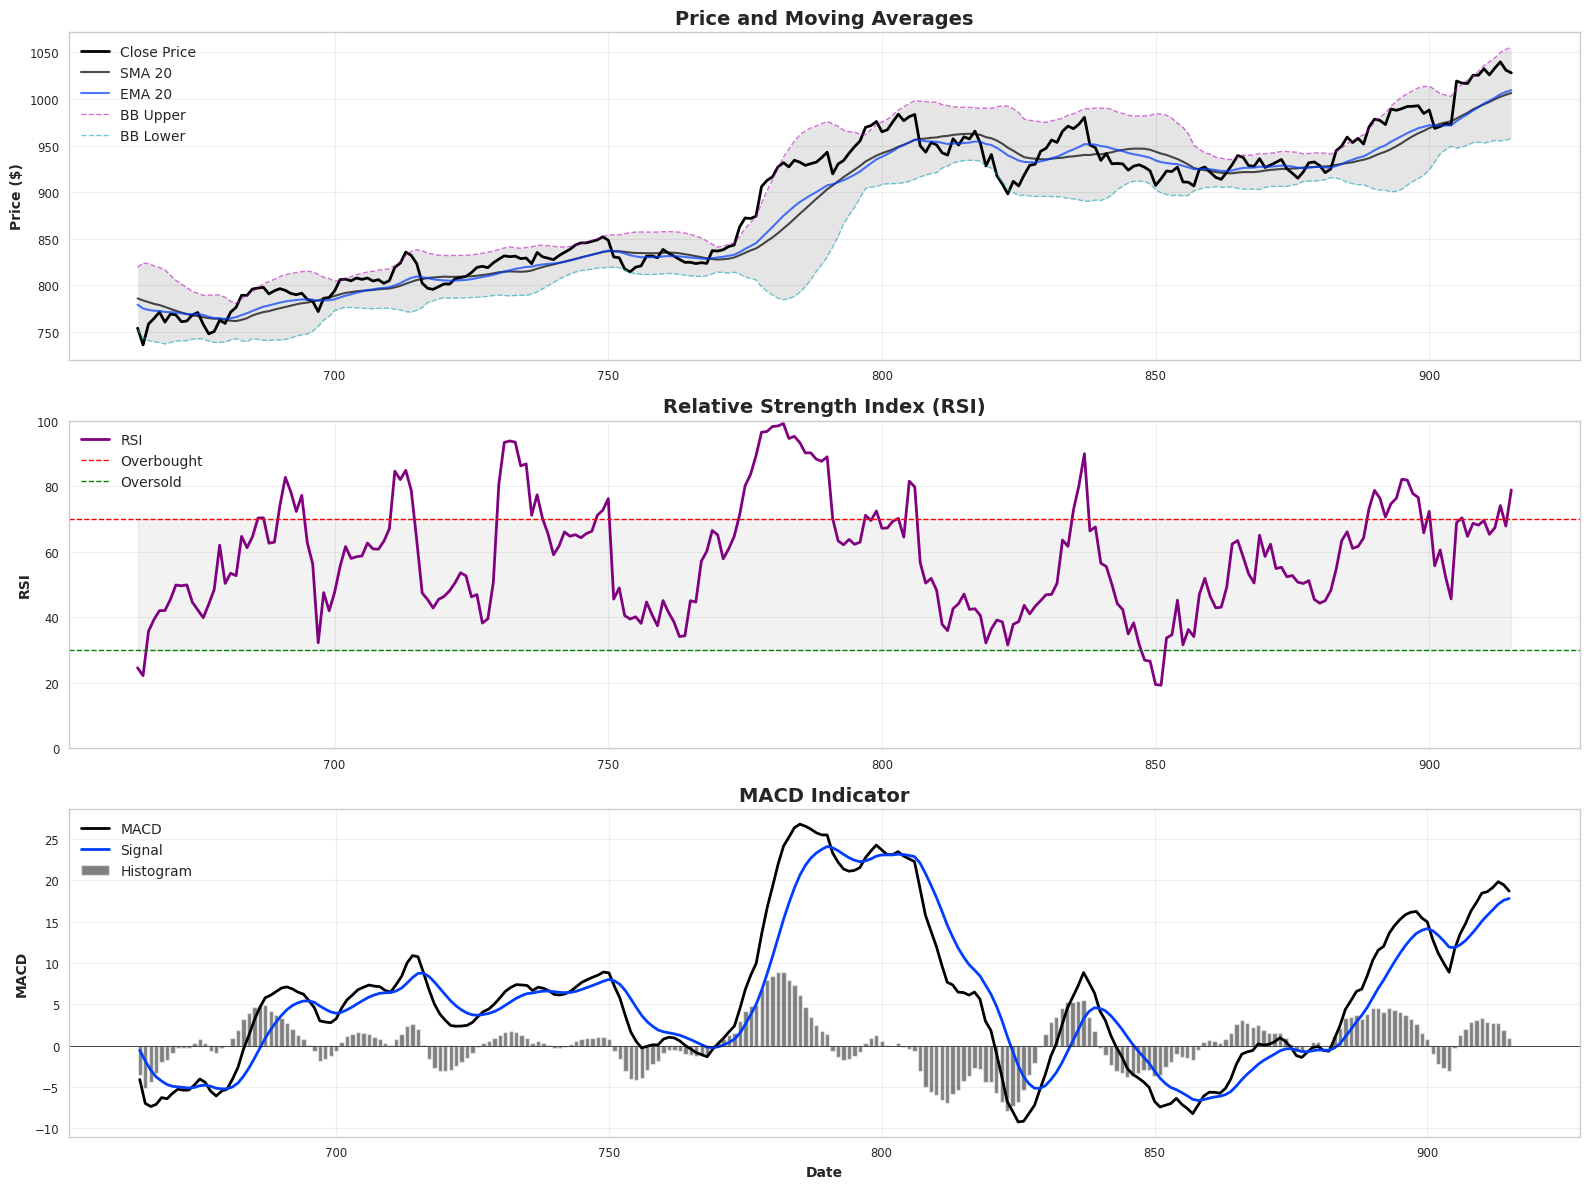

Technical indicators visualization complete


In [6]:
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

recent_df = df.tail(252)
ax1 = axes[0]
ax1.plot(recent_df.index, recent_df['Close'], label='Close Price', linewidth=2, color='black')
ax1.plot(recent_df.index, recent_df['SMA_20'], label='SMA 20', linewidth=1.5, alpha=0.7)
ax1.plot(recent_df.index, recent_df['EMA_20'], label='EMA 20', linewidth=1.5, alpha=0.7)
ax1.plot(recent_df.index, recent_df['BB_Upper'], label='BB Upper', linewidth=1, linestyle='--', alpha=0.6)
ax1.plot(recent_df.index, recent_df['BB_Lower'], label='BB Lower', linewidth=1, linestyle='--', alpha=0.6)
ax1.fill_between(recent_df.index, recent_df['BB_Upper'], recent_df['BB_Lower'], alpha=0.1)
ax1.set_title('Price and Moving Averages', fontsize=14, fontweight='bold')
ax1.set_ylabel('Price ($)')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

ax2 = axes[1]
ax2.plot(recent_df.index, recent_df['RSI'], label='RSI', linewidth=2, color='purple')
ax2.axhline(y=70, color='r', linestyle='--', linewidth=1, label='Overbought')
ax2.axhline(y=30, color='g', linestyle='--', linewidth=1, label='Oversold')
ax2.fill_between(recent_df.index, 30, 70, alpha=0.1, color='gray')
ax2.set_title('Relative Strength Index (RSI)', fontsize=14, fontweight='bold')
ax2.set_ylabel('RSI')
ax2.set_ylim(0, 100)
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

ax3 = axes[2]
ax3.plot(recent_df.index, recent_df['MACD'], label='MACD', linewidth=2)
ax3.plot(recent_df.index, recent_df['MACD_Signal'], label='Signal', linewidth=2)
ax3.bar(recent_df.index, recent_df['MACD_Histogram'], label='Histogram', alpha=0.5)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax3.set_title('MACD Indicator', fontsize=14, fontweight='bold')
ax3.set_xlabel('Date')
ax3.set_ylabel('MACD')
ax3.legend(loc='upper left')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Technical indicators visualization complete")

---

## Cell 7: Select Features for Training

### Feature Selection Rationale

We select 13 features combining raw OHLCV data with derived technical indicators.

**Why Include Both Raw and Derived Features?**
- **Raw features** (Close, Open, High, Low, Volume): Provide absolute price levels and trading range
- **Technical indicators**: Provide normalized, relative measures of trend, momentum, and volatility
- **Complementary information**: Neural networks can learn complex interactions between raw and derived features

**Selected Features (13 total):**
1. **Price data** (4): Close, Open, High, Low - capture daily price range
2. **Volume** (1): Trading activity intensity
3. **Trend** (2): SMA_20, EMA_20 - moving averages at 20-day window
4. **Momentum** (3): RSI, MACD, MACD_Signal - momentum and trend change signals
5. **Volatility** (2): BB_Width, ATR - volatility measures
6. **Volume analysis** (1): Volume_Ratio - normalized volume indicator

This combination provides the model with multiple perspectives on market dynamics.

In [7]:
feature_cols = [
    'Close', 'Open', 'High', 'Low', 'Volume',
    'SMA_20', 'EMA_20', 'RSI', 'MACD', 'MACD_Signal',
    'BB_Width', 'ATR', 'Volume_Ratio'
]

target_col = 'Price_Change_Pct'

print(f"Selected features ({len(feature_cols)}):")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:2d}. {col}")

print(f"\nTarget variable: {target_col}")
print(f"Note: Model predicts percentage change (e.g., 0.1 = 10% increase)")

Selected features (13):
   1. Close
   2. Open
   3. High
   4. Low
   5. Volume
   6. SMA_20
   7. EMA_20
   8. RSI
   9. MACD
  10. MACD_Signal
  11. BB_Width
  12. ATR
  13. Volume_Ratio

Target variable: Price_Change_Pct
Note: Model predicts percentage change (e.g., 0.1 = 10% increase)


---

## Cell 8: Split Data Chronologically

### Chronological Splitting Strategy

**Critical Design Decision**: We enforce strict chronological splitting to prevent look-ahead bias.

**Split Ratios:**
- **Training**: 70% (earliest historical data)
- **Validation**: 15% (middle period)
- **Test**: 15% (most recent data)

### Why Chronological Splitting Matters

**Look-Ahead Bias Prevention**: Random splitting would leak future information into training. If data from 2024 appears in training while 2023 data is in validation, the model could learn patterns that haven't occurred yet, artificially inflating performance metrics.

Chronological splitting ensures the model only learns from the past to predict the future, matching the real-world deployment scenario.

### Validation vs Test Sets

**Validation Set Purpose:**
1. Hyperparameter tuning without touching test data
2. Early stopping to prevent overfitting
3. Learning rate scheduling decisions

**Test Set Purpose:**
- Remains completely unseen until final evaluation
- Provides unbiased estimate of production performance
- Simulates real-world forecasting on future data

The visualization below shows how the data is split chronologically, with no temporal overlap between sets.

Data Split Summary
Training set:     606 samples (49 to 654)
Validation set:   130 samples (655 to 784)
Test set:         131 samples (785 to 915)


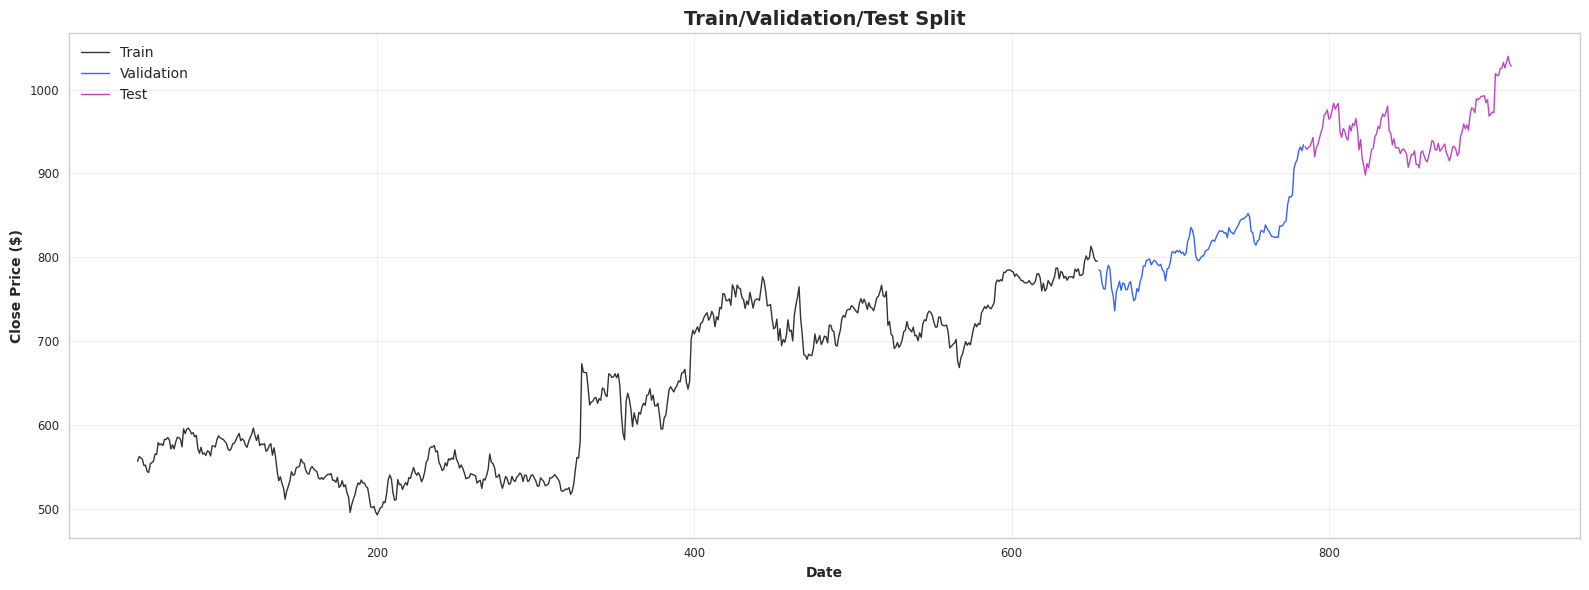

In [8]:
train_df, val_df, test_df = split_data_chronological(df, train_ratio=0.7, val_ratio=0.15)

print("=" * 60)
print("Data Split Summary")
print("=" * 60)
print(f"Training set:   {len(train_df):5d} samples ({train_df.index.min()} to {train_df.index.max()})")
print(f"Validation set: {len(val_df):5d} samples ({val_df.index.min()} to {val_df.index.max()})")
print(f"Test set:       {len(test_df):5d} samples ({test_df.index.min()} to {test_df.index.max()})")
print("=" * 60)

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(train_df.index, train_df['Close'], label='Train', linewidth=1, alpha=0.8)
ax.plot(val_df.index, val_df['Close'], label='Validation', linewidth=1, alpha=0.8)
ax.plot(test_df.index, test_df['Close'], label='Test', linewidth=1, alpha=0.8)
ax.set_title('Train/Validation/Test Split', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price ($)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---

## Cell 9: Normalize Features

### Normalization Architecture

Feature scaling improves neural network training by ensuring all features contribute equally to gradient updates.

**MinMax Scaling Strategy**: Maps all features to the [0, 1] range while preserving distribution shape.

```
Scaled_value = (value - min) / (max - min)
```

### Critical Implementation Details

**Fit on Training Only**: The scaler is fit ONLY on training data, then applied to validation and test sets using the same transformation parameters. This prevents data leakage.

Why is this critical? If we fit the scaler on all data:
- Test set statistics would leak into training normalization
- Model would have implicit knowledge of test data distribution
- Performance metrics would be artificially inflated

**Include Target in Normalization**: We normalize the target variable (percentage change) along with features because:
1. Neural networks work best with inputs/outputs in similar ranges
2. We need consistent scaling for denormalization later
3. The same scaler handles both forward (normalization) and inverse (denormalization) transforms

**Scaler Persistence**: The fitted scaler must be saved alongside the model because production inference requires:
1. Scaling new input features using training parameters
2. Inverse transforming predictions back to original scale

Without the original scaler, predictions cannot be interpreted correctly.

In [9]:
# Include target column in normalization
all_cols = feature_cols + [target_col]

train_scaled, scaler = normalize_data(train_df, columns=all_cols, scaler_type='minmax')

val_scaled = val_df.copy()
val_scaled[all_cols] = scaler.transform(val_df[all_cols])

test_scaled = test_df.copy()
test_scaled[all_cols] = scaler.transform(test_df[all_cols])

print("Feature normalization complete")
print(f"\nScaler range: {scaler.feature_range}")
print(f"\nSample scaled values (first 5 rows, first 5 features):")
print(train_scaled[feature_cols].head())
print(f"\nTarget variable range in training set:")
print(f"  Original: [{train_df[target_col].min():.6f}, {train_df[target_col].max():.6f}]")
print(f"  Scaled:   [{train_scaled[target_col].min():.6f}, {train_scaled[target_col].max():.6f}]")

Feature normalization complete

Scaler range: (0, 1)

Sample scaled values (first 5 rows, first 5 features):
       Close      Open      High       Low    Volume    SMA_20    EMA_20  \
49  0.198964  0.196907  0.193577  0.193243  0.113277  0.109431  0.125425   
50  0.217026  0.193584  0.208669  0.215631  0.093869  0.117273  0.131076   
51  0.212129  0.204515  0.210851  0.221487  0.077289  0.122809  0.135656   
52  0.206794  0.196721  0.199252  0.212419  0.053577  0.127463  0.139220   
53  0.183429  0.195572  0.193358  0.191763  0.087328  0.131928  0.139907   

         RSI      MACD  MACD_Signal  BB_Width       ATR  Volume_Ratio  
49  0.752134  0.442501     0.442497  0.205070  0.191834      0.173639  
50  0.740452  0.454618     0.451902  0.197190  0.173512      0.151551  
51  0.716287  0.459960     0.460786  0.197219  0.158998      0.130396  
52  0.640114  0.459699     0.467827  0.196146  0.145685      0.097586  
53  0.507342  0.445367     0.469810  0.181967  0.151587      0.147278  

T

---

## Cell 10: Create Sequences for LSTM

### Sequence Creation Design

LSTM models require sequential input structured as sliding windows over historical data.

**Window Architecture**: Each sequence consists of 60 consecutive days of 13 features, creating a 3D tensor:
```
Shape: (n_sequences, 60, 13)
       (samples, time_steps, features)
```

### Sliding Window Mechanics

With `step_size=1`, windows overlap maximally:
- Sequence 1: Days 0-59 → Predict Day 60
- Sequence 2: Days 1-60 → Predict Day 61
- Sequence 3: Days 2-61 → Predict Day 62

This overlapping strategy maximizes training data from limited historical records.

### Design Decision: 60-Day Window

The 60-day window length balances multiple factors:
- **Sufficient history**: Captures medium-term patterns (≈3 months of trading days)
- **Gradient stability**: Not too long to cause vanishing gradients in LSTM
- **Industry standard**: Common practice in financial forecasting
- **Seasonality**: Captures quarterly patterns without being too computationally expensive

### Target Alignment

The target for each sequence is the percentage change at the next time step (day 61 for sequence ending at day 60). This creates a one-step-ahead forecasting task:
- Input: Days 0-59 features
- Output: Percentage change on day 60

We reshape targets to `(n_samples, 1)` for single-output regression.

In [10]:
sequence_length = 60

# Create sequences with features only (X) and target separately (y)
X_train, _ = create_rolling_windows(
    train_scaled[feature_cols].values,
    window_size=sequence_length,
    step_size=1
)

X_val, _ = create_rolling_windows(
    val_scaled[feature_cols].values,
    window_size=sequence_length,
    step_size=1
)

X_test, _ = create_rolling_windows(
    test_scaled[feature_cols].values,
    window_size=sequence_length,
    step_size=1
)

# Extract target (percentage change) separately
# Target is the percentage change at the next time step
y_train = train_scaled[target_col].values[sequence_length:]
y_val = val_scaled[target_col].values[sequence_length:]
y_test = test_scaled[target_col].values[sequence_length:]

# Reshape to (n_samples, 1) for single output
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print("=" * 60)
print("Sequence Creation Summary")
print("=" * 60)
print(f"Sequence length: {sequence_length} days")
print(f"Number of features: {len(feature_cols)}")
print(f"Target: {target_col} (percentage change)")
print(f"\nTraining sequences:   X={X_train.shape}, y={y_train.shape}")
print(f"Validation sequences: X={X_val.shape}, y={y_val.shape}")
print(f"Test sequences:       X={X_test.shape}, y={y_test.shape}")
print("=" * 60)

Sequence Creation Summary
Sequence length: 60 days
Number of features: 13
Target: Price_Change_Pct (percentage change)

Training sequences:   X=(546, 60, 13), y=(546, 1)
Validation sequences: X=(70, 60, 13), y=(70, 1)
Test sequences:       X=(71, 60, 13), y=(71, 1)


---

## Cell 11: Build and Train LSTM Model

### LSTM Architecture Design

The LSTM uses a two-layer recurrent network for sequential pattern learning.

**Layer Configuration:**

1. **LSTM Layer 1** (512 units, return_sequences=True)
   - Processes input sequence and returns hidden states for all time steps
   - Large unit count provides capacity for complex pattern learning
   - Returns sequences to feed into second LSTM layer

2. **Dropout** (20%): Prevents overfitting by randomly dropping connections

3. **LSTM Layer 2** (256 units, return_sequences=False)
   - Processes hidden states from first layer
   - Returns only final hidden state (sequence summary)
   - Effectively compresses temporal information

4. **Dropout** (20%): Additional regularization

5. **Dense Layer** (128 units, ReLU): Non-linear transformation of LSTM output

6. **Dropout** (20%): Final regularization before output

7. **Output Layer** (1 unit, linear activation): Predicts percentage change as continuous value

**Design Rationale:**
- **Two LSTM layers**: Captures patterns at different temporal scales
- **Decreasing units** (512 → 256): Hierarchical feature compression
- **Consistent dropout** (20%): Prevents overfitting without excessive regularization
- **Linear output**: Percentage change is unbounded, requires linear activation

### Training Configuration

**Loss Function**: MAE (Mean Absolute Error)
- Less sensitive to outliers than MSE
- Directly measures average prediction error in percentage points
- Matches business metric (average forecast error)

**Optimizer**: Adam with learning_rate=0.001
- Adaptive learning rates for each parameter
- Momentum and RMSprop benefits combined
- Standard choice for time series forecasting

**Callbacks:**
1. **Early Stopping** (patience=10): Stops if validation loss doesn't improve for 10 epochs
2. **Learning Rate Reduction** (patience=5): Halves learning rate when validation plateaus
3. **Model Checkpointing**: Saves best model weights based on validation loss

These callbacks prevent overfitting and ensure the best model is preserved even if training continues past optimal point.

Building and training LSTM model...
Loss function: MAE (Mean Absolute Error)
Optimizer: Adam
Building LSTM model with config: LSTMConfig(sequence_length=60, n_features=13, lstm_units_1=512, lstm_units_2=256, dropout_rate=0.2, dense_units=128, output_dim=1, learning_rate=0.001, batch_size=32, epochs=50, validation_split=0.0)

Model Architecture:


2025-12-11 15:06:29.093388: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 512)        │     1,077,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 256)            │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼─────────────────────

18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 313ms/step - loss: 0.0554 - mae: 0.0554 - mape: 500887.5000 - val_loss: 0.0262 - val_mae: 0.0262 - val_mape: 11.1275 - learning_rate: 5.0000e-04
Epoch 18/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 0.0532 - mae: 0.0532 - mape: 243159.4599
Epoch 18: val_loss did not improve from 0.02621
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 246ms/step - loss: 0.0526 - mae: 0.0526 - mape: 449992.0625 - val_loss: 0.0285 - val_mae: 0.0285 - val_mape: 12.3294 - learning_rate: 5.0000e-04
Epoch 19/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - loss: 0.0550 - mae: 0.0550 - mape: 89149.9537
Epoch 19: val_loss did not improve from 0.02621
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 269ms/step - loss: 0.0544 - mae: 0.0544 - mape: 380415.5625 - val_loss: 0.0286 - val_mae: 0.0286 - val_mape: 11.3618 - learning_rate: 5.0000e-04
Epoch 20/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - loss: 0.0566 - mae: 0.0566 - mape: 434495.1641
Epoch 20: val_loss did not improve from 0.02621

Epoch 20: ReduceLROnPlate

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - loss: 0.0512 - mae: 0.0512 - mape: 1507722.2569
Epoch 37: val_loss did not improve from 0.02542
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 278ms/step - loss: 0.0506 - mae: 0.0506 - mape: 454755.3125 - val_loss: 0.0265 - val_mae: 0.0265 - val_mape: 10.8008 - learning_rate: 6.2500e-05
Epoch 38/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - loss: 0.0522 - mae: 0.0522 - mape: 926943.2787
Epoch 38: val_loss did not improve from 0.02542
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 220ms/step - loss: 0.0521 - mae: 0.0521 - mape: 391505.5938 - val_loss: 0.0276 - val_mae: 0.0276 - val_mape: 11.0696 - learning_rate: 6.2500e-05
Epoch 39/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - loss: 0.0539 - mae: 0.0539 - mape: 294983.8825
Epoch 39: val_loss did not improve from 0.02542

Epoch 39: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 281ms/step - loss: 0.0504 - mae: 0.0504 - mape: 464653.2500 - val_loss: 0.0288 - val_mae: 0.0288 - val_

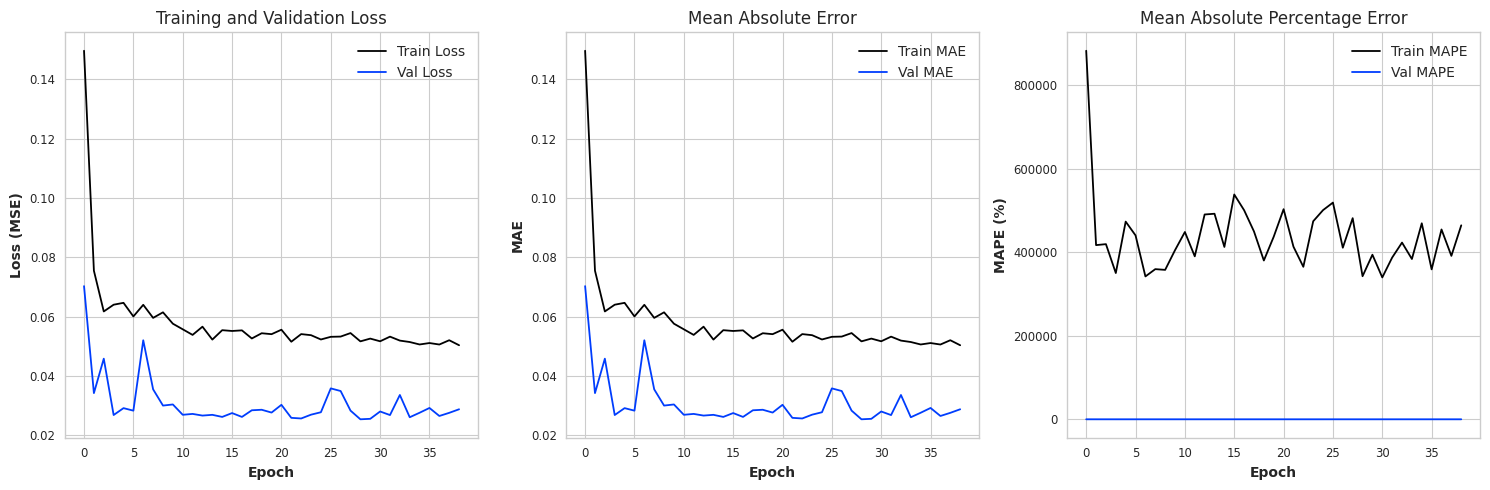


Training complete. Files saved:
  keras_model: models/lstm_model.keras
  history: models/training_history.json
  plot: models/training_curves.png

Training Complete!


In [11]:
config = LSTMConfig(
    sequence_length=sequence_length,
    n_features=len(feature_cols),
    lstm_units_1=512,
    lstm_units_2=256,
    dropout_rate=0.2,
    dense_units=128,
    output_dim=1,  # Single output: percentage change prediction
    learning_rate=0.001,
    batch_size=32,
    epochs=50,
    validation_split=0.0
)

print("Building and training LSTM model...")
print("=" * 60)
print("Loss function: MAE (Mean Absolute Error)")
print("Optimizer: Adam")
print("=" * 60)

import os
os.makedirs('models', exist_ok=True)

model, history, file_paths = create_and_train_lstm(
    X_train, y_train,
    X_val, y_val,
    config=config,
    model_dir='models',
    verbose=1
)

print("\n" + "=" * 60)
print("Training Complete!")
print("=" * 60)

---

## Cell 13: Convert Model to ONNX

### ONNX Conversion Strategy

ONNX (Open Neural Network Exchange) provides a framework-agnostic format for deploying models with optimized inference.

**Why Convert to ONNX?**
1. **Performance**: 2-5x faster inference through graph optimizations
2. **Portability**: Deploy across platforms (cloud, edge, mobile)
3. **Production-ready**: Optimized operator kernels and memory management
4. **Framework agnostic**: Works with TensorFlow, PyTorch, scikit-learn models

### Keras LSTM Conversion Challenge

Standard Keras LSTM layers use CuDNN optimization for training speed, but CuDNN's fused implementation doesn't translate to ONNX operators.

**Solution (automated in conversion function):**
1. Load trained Keras model and extract configuration
2. Modify LSTM layer configs to set `use_cudnn=False`
3. Recreate model from modified configuration
4. Transfer trained weights from original to new model
5. Call model once to build the graph (Keras 3 requirement)
6. Export to ONNX format

This process is transparent to the user, handled automatically by the wrapper function.

### Model Size Comparison

ONNX models are typically similar in size to Keras models, sometimes slightly larger due to explicit graph representation. The performance benefits come from runtime optimizations, not compression.

In [12]:
print("Converting Keras model to ONNX format...\n")

onnx_model_path = 'models/stock_forecast_lstm.onnx'

onnx_path = convert_to_onnx(
    model_path='models/lstm_model.keras',
    onnx_path=onnx_model_path,
)

print(f"Model converted successfully!")
print(f"ONNX model saved to: {onnx_path}")

import os
keras_size = os.path.getsize('models/lstm_model.keras') / 1024
onnx_size = os.path.getsize(onnx_path) / 1024

print(f"\nModel Size Comparison:")
print(f"  Keras (.keras):  {keras_size:.2f} KB")
print(f"  ONNX (.onnx): {onnx_size:.2f} KB")
print(f"  Compression:  {keras_size/onnx_size:.2f}x")

Converting Keras model to ONNX format...



I0000 00:00:1765465792.819932      13 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00:1765465792.820149      13 single_machine.cc:374] Starting new session
I0000 00:00:1765465793.002319      13 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00:1765465793.002613      13 single_machine.cc:374] Starting new session
I0000 00:00:1765465793.184991      13 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled


Saved artifact at 'models/stock_forecast_lstm.onnx'.
Model converted successfully!
ONNX model saved to: models/stock_forecast_lstm.onnx

Model Size Comparison:
  Keras (.keras):  22282.08 KB
  ONNX (.onnx): 7429.55 KB
  Compression:  3.00x


---

## Cell 14: Verify ONNX Model

### Verification Strategy

After conversion, comprehensive verification ensures the ONNX model is valid and ready for deployment.

**Verification Checks:**

1. **Schema Validation**: Checks ONNX graph structure against specification
   - Ensures graph is well-formed
   - Validates node connections and data flow

2. **Operator Validation**: Ensures all operators are supported by target opset version
   - Verifies operator compatibility
   - Checks operator attributes and parameters

3. **Shape Inference**: Validates tensor shapes propagate correctly through graph
   - Catches shape mismatches
   - Ensures input/output shapes are correct

4. **Model Information**: Extracts metadata
   - Opset version (ONNX standard version)
   - Number of nodes (computational complexity indicator)
   - Producer information

Only models that pass all verification steps should proceed to deployment. Invalid models may have conversion errors or unsupported operations that would fail at runtime.

In [13]:
verification = verify_onnx(onnx_model_path)

print("=" * 60)
print("ONNX Model Verification")
print("=" * 60)
print(f"Valid:              {verification['is_valid']}")
print(f"Error:              {verification['error']}")
print(f"Opset Version:      {verification['opset_version']}")
print(f"Number of Nodes:    {verification['num_nodes']}")
print("=" * 60)

if verification['is_valid']:
    print("\nONNX model is valid and ready for deployment!")
else:
    print(f"\nVerification failed: {verification['error']}")
    raise Exception

ONNX Model Verification
Valid:              True
Error:              None
Opset Version:      15
Number of Nodes:    28

ONNX model is valid and ready for deployment!


---

## Cell 15: Compare TensorFlow vs ONNX Inference

### Performance Benchmarking Methodology

We benchmark inference performance to quantify ONNX Runtime advantages over TensorFlow/Keras.

**Test Setup:**
- Same 100 samples from test set
- Identical hardware (CPU or GPU)
- Warm-up runs to eliminate initialization effects
- Average over multiple runs for statistical stability

**Metrics:**

1. **Inference Time**: Wall-clock time for forward pass
2. **Speedup**: TensorFlow time / ONNX time
3. **Numerical Difference**: Maximum and mean absolute difference between predictions
4. **Equivalence Check**: Whether predictions are within floating-point tolerance (1e-5)

### Expected Performance

**Typical Results for LSTM models:**
- **CPU**: 2-3x speedup with ONNX Runtime
- **GPU**: 1.5-2x speedup (less relative improvement due to TensorFlow GPU optimization)
- **Numerical accuracy**: Within floating-point precision (differences < 1e-6)

### Why ONNX is Faster

ONNX Runtime provides consistent performance improvements through:
1. **Graph optimizations**: Operator fusion, constant folding, redundant node elimination
2. **Efficient kernels**: Hand-optimized operator implementations
3. **Memory management**: Better memory layout and reduced allocations
4. **Platform-specific tuning**: CPU vectorization, GPU kernel optimizations

The numerical difference should be negligible (< 1e-5), confirming that optimizations preserve model accuracy.

In [14]:
print("Comparing TensorFlow vs ONNX Runtime performance...\n")

comparison = compare_frameworks_inference(
    keras_model_path='models/lstm_model.keras',
    onnx_model_path=onnx_model_path,
    test_input=X_test[:100]
)

print("=" * 70)
print("Framework Comparison Results")
print("=" * 70)
print(f"TensorFlow inference time:  {comparison['tensorflow_time']:.6f} seconds")
print(f"ONNX Runtime inference time: {comparison['onnx_time']:.6f} seconds")
print(f"Speedup:                     {comparison['speedup']:.2f}x")
print("-" * 70)
print(f"Max numerical difference:    {comparison['max_difference']:.2e}")
print(f"Mean numerical difference:   {comparison['mean_difference']:.2e}")
print(f"Numerically equivalent:      {comparison['numerically_close']}")
print("=" * 70)

if comparison['speedup'] > 1:
    print(f"\nONNX Runtime is {comparison['speedup']:.2f}x faster!")
else:
    print(f"\nTensorFlow is {1/comparison['speedup']:.2f}x faster")

if comparison['numerically_close']:
    print("Models produce numerically equivalent results")

Comparing TensorFlow vs ONNX Runtime performance...

Framework Comparison Results
TensorFlow inference time:  0.635231 seconds
ONNX Runtime inference time: 0.051553 seconds
Speedup:                     12.32x
----------------------------------------------------------------------
Max numerical difference:    8.94e-08
Mean numerical difference:   2.35e-08
Numerically equivalent:      True

ONNX Runtime is 12.32x faster!
Models produce numerically equivalent results


---

## Cell 16: Run Inference with ONNX Runtime

### ONNX Inference Pipeline

The production inference pipeline follows these steps:

1. **Load ONNX Model**: Create ONNXInferenceSession with optimized runtime
2. **Run Inference**: Forward pass on test sequences (returns scaled percentage changes)
3. **Denormalize Predictions**: Inverse transform to original percentage scale
4. **Reconstruct Prices**: Convert percentage changes to actual price predictions

### Denormalization Process

**Challenge**: We normalized all features together, so denormalization requires reconstructing the full feature vector.

**Solution**:
1. Create dummy array with shape (n_samples, n_features)
2. Place predictions in the target column position
3. Apply inverse transform using the saved scaler
4. Extract denormalized predictions from target column

This ensures we use the correct scaling parameters from training.

### Price Reconstruction

While the model predicts percentage changes, we reconstruct actual prices for intuitive interpretation:

```
Predicted_Price_t = Price_t-1 × (1 + Predicted_Percentage_Change)
```

For example:
- Previous close: $100
- Predicted change: +0.025 (2.5%)
- Predicted price: $100 × (1 + 0.025) = $102.50

### Dual-Level Predictions

We maintain both:
- **Percentage predictions**: What the model actually predicts (primary metric)
- **Price predictions**: Reconstructed for visualization and business interpretation (secondary metric)


In [15]:
print("Running inference with ONNX Runtime...\n")

onnx_session = ONNXInferenceSession(onnx_model_path)

print(f"Input shape: {onnx_session.get_input_shape()}")
print(f"Output shape: {onnx_session.get_output_shape()}")

# Get predictions (scaled percentage changes)
onnx_predictions_scaled = onnx_session.predict(X_test)

# Denormalize percentage change predictions
# We need to create a dummy array with all features to use the scaler
target_col_idx = all_cols.index(target_col)
dummy_array = np.zeros((len(onnx_predictions_scaled), len(all_cols)))
dummy_array[:, target_col_idx] = onnx_predictions_scaled.flatten()
onnx_predictions_pct = scaler.inverse_transform(dummy_array)[:, target_col_idx]

# Denormalize actual percentage changes
dummy_array_actual = np.zeros((len(y_test), len(all_cols)))
dummy_array_actual[:, target_col_idx] = y_test.flatten()
y_test_pct = scaler.inverse_transform(dummy_array_actual)[:, target_col_idx]

# Convert percentage changes to actual prices for visualization
# We need the previous close price for each prediction
test_close_prices = test_df['Close'].values[sequence_length-1:sequence_length-1+len(y_test_pct)]

# Predicted price = Previous close * (1 + predicted percentage change)
onnx_predictions_unscaled = test_close_prices * (1 + onnx_predictions_pct)

# Actual price = Previous close * (1 + actual percentage change)
y_test_unscaled = test_close_prices * (1 + y_test_pct)

print(f"\nInference complete!")
print(f"Number of predictions: {len(onnx_predictions_scaled)}")
print(f"\nSample predictions (percentage change):")
for i in range(min(5, len(onnx_predictions_pct))):
    print(f"  Predicted: {onnx_predictions_pct[i]:+.4f} ({onnx_predictions_pct[i]*100:+.2f}%), " +
          f"Actual: {y_test_pct[i]:+.4f} ({y_test_pct[i]*100:+.2f}%)")

Running inference with ONNX Runtime...

Input shape: ['unk__130', 60, 13]
Output shape: ['unk__131', 1]

Inference complete!
Number of predictions: 71

Sample predictions (percentage change):
  Predicted: +0.0051 (+0.51%), Actual: -0.0072 (-0.72%)
  Predicted: +0.0052 (+0.52%), Actual: +0.0047 (+0.47%)
  Predicted: +0.0051 (+0.51%), Actual: +0.0015 (+0.15%)
  Predicted: +0.0051 (+0.51%), Actual: -0.0028 (-0.28%)
  Predicted: +0.0050 (+0.50%), Actual: -0.0042 (-0.42%)


---

## Cell 17: Evaluate Forecast Performance

In [16]:
# Evaluate on percentage change predictions (primary metric)
pct_mae = np.mean(np.abs(y_test_pct - onnx_predictions_pct))
pct_rmse = np.sqrt(np.mean((y_test_pct - onnx_predictions_pct) ** 2))
pct_r2 = 1 - (np.sum((y_test_pct - onnx_predictions_pct) ** 2) / np.sum((y_test_pct - y_test_pct.mean()) ** 2))

# Directional accuracy (did we predict the right direction?)
correct_direction = np.sum((y_test_pct > 0) == (onnx_predictions_pct > 0))
directional_accuracy_pct = (correct_direction / len(y_test_pct)) * 100

print("=" * 70)
print("Percentage Change Prediction Performance (Primary Metric)")
print("=" * 70)
print(f"Mean Absolute Error (MAE):       {pct_mae:.6f} ({pct_mae*100:.4f}%)")
print(f"Root Mean Squared Error (RMSE):  {pct_rmse:.6f} ({pct_rmse*100:.4f}%)")
print(f"R² Score:                        {pct_r2:.4f}")
print(f"Directional Accuracy:            {directional_accuracy_pct:.2f}%")
print("=" * 70)

# Also evaluate on reconstructed prices (secondary metric for comparison)
metrics = evaluate_forecasts(y_test_unscaled, onnx_predictions_unscaled)

print("\n" + "=" * 70)
print("Reconstructed Price Forecasting Performance (Secondary Metric)")
print("=" * 70)
print(f"Mean Absolute Error (MAE):       ${metrics['MAE']:.4f}")
print(f"Root Mean Squared Error (RMSE):  ${metrics['RMSE']:.4f}")
print(f"Mean Absolute % Error (MAPE):    {metrics['MAPE']:.2f}%")
print(f"R² Score:                        {metrics['R2']:.4f}")
print(f"Directional Accuracy:            {metrics['Directional_Accuracy']:.2f}%")
print("=" * 70)

avg_price = y_test_unscaled.mean()
print(f"\nAverage stock price: ${avg_price:.2f}")
print(f"MAE as % of avg price: {(metrics['MAE'] / avg_price) * 100:.2f}%")

if directional_accuracy_pct > 55:
    print(f"\nGood directional accuracy: {directional_accuracy_pct:.1f}% > 55%")
else:
    print(f"\nNote: Directional accuracy {directional_accuracy_pct:.1f}% (random = 50%)")

Percentage Change Prediction Performance (Primary Metric)
Mean Absolute Error (MAE):       0.007434 (0.7434%)
Root Mean Squared Error (RMSE):  0.010150 (1.0150%)
R² Score:                        -0.0741
Directional Accuracy:            53.52%

Reconstructed Price Forecasting Performance (Secondary Metric)
Mean Absolute Error (MAE):       $7.0812
Root Mean Squared Error (RMSE):  $9.6924
Mean Absolute % Error (MAPE):    0.74%
R² Score:                        0.9383
Directional Accuracy:            47.14%

Average stock price: $955.33
MAE as % of avg price: 0.74%

Note: Directional accuracy 53.5% (random = 50%)


---

## Cell 18: Visualize Predictions vs Actual

### Visualization Strategy

Visual inspection complements numerical metrics by revealing patterns in prediction errors.

**What to Look For:**

1. **Overall Fit**: Do predictions track actual prices reasonably well?
2. **Lag**: Does the model predict late, showing yesterday's trend?
3. **Volatility Capture**: Does the model respond to rapid price changes?
4. **Systematic Bias**: Are predictions consistently high or low?
5. **Extreme Events**: How does the model handle large price movements?

**Full Test Set View**: Shows overall performance across the entire test period, revealing any time-dependent patterns in accuracy.

**Recent Window View**: Focuses on the most recent year (252 trading days) for detailed inspection. Recent performance is often most relevant for assessing current model fitness.

A good model should:
- Follow the general price trend
- Not systematically lag or lead
- Capture both up and down movements
- Show similar volatility to actual prices

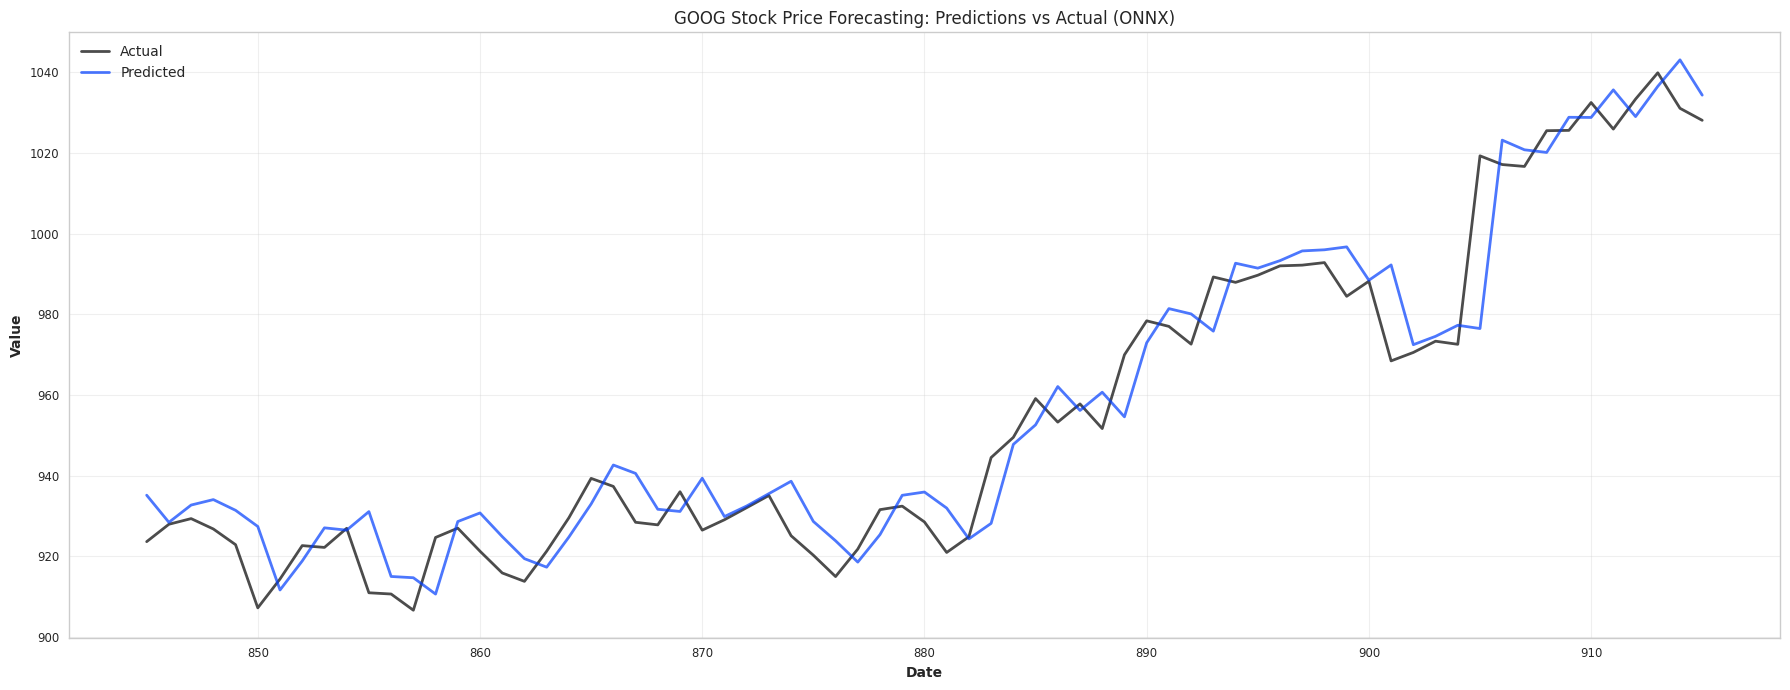

In [17]:
test_dates = test_df.index[sequence_length:sequence_length + len(y_test_unscaled)]

plot_predictions_vs_actual(
    y_true=y_test_unscaled,
    y_pred=onnx_predictions_unscaled,
    dates=test_dates,
    title='GOOG Stock Price Forecasting: Predictions vs Actual (ONNX)',
    figsize=(18, 7)
)

recent_window = 252
if len(y_test_unscaled) > recent_window:
    plot_predictions_vs_actual(
        y_true=y_test_unscaled[-recent_window:],
        y_pred=onnx_predictions_unscaled[-recent_window:],
        dates=test_dates[-recent_window:],
        title='GOOG Stock Price Forecasting: Last Year (ONNX)',
        figsize=(18, 7)
    )

---

## Cell 20: Sample Predictions Table

In [18]:
sample_size = 20
sample_indices = np.linspace(0, len(y_test_unscaled) - 1, sample_size, dtype=int)

results_df = pd.DataFrame({
    'Date': test_dates[sample_indices],
    'Actual % Chg': y_test_pct[sample_indices] * 100,
    'Pred % Chg': onnx_predictions_pct[sample_indices] * 100,
    'Actual Price': y_test_unscaled[sample_indices],
    'Pred Price': onnx_predictions_unscaled[sample_indices],
    'Price Error': y_test_unscaled[sample_indices] - onnx_predictions_unscaled[sample_indices]
})

# Format for display
results_df['Actual % Chg'] = results_df['Actual % Chg'].apply(lambda x: f"{x:+.2f}%")
results_df['Pred % Chg'] = results_df['Pred % Chg'].apply(lambda x: f"{x:+.2f}%")
results_df['Actual Price'] = results_df['Actual Price'].apply(lambda x: f"${x:.2f}")
results_df['Pred Price'] = results_df['Pred Price'].apply(lambda x: f"${x:.2f}")
results_df['Price Error'] = results_df['Price Error'].apply(lambda x: f"${x:.2f}")

print("Sample Predictions (Percentage Change & Reconstructed Prices):")
print(results_df.to_string(index=False))

Sample Predictions (Percentage Change & Reconstructed Prices):
 Date Actual % Chg Pred % Chg Actual Price Pred Price Price Error
  845       -0.72%     +0.51%      $923.65    $935.16     $-11.51
  848       -0.28%     +0.51%      $926.79    $934.07      $-7.28
  852       +0.91%     +0.49%      $922.67    $918.86       $3.81
  856       -0.03%     +0.44%      $910.67    $915.02      $-4.35
  859       +0.25%     +0.43%      $927.00    $928.63      $-1.63
  863       +0.82%     +0.38%      $921.29    $917.32       $3.97
  867       -0.95%     +0.34%      $928.45    $940.57     $-12.12
  870       -1.02%     +0.36%      $926.50    $939.37     $-12.87
  874       -1.07%     +0.38%      $925.11    $938.62     $-13.51
  878       +1.06%     +0.39%      $931.58    $925.40       $6.18
  881       -0.81%     +0.37%      $920.97    $931.97     $-11.00
  885       +1.01%     +0.33%      $959.11    $952.60       $6.51
  889       +1.92%     +0.31%      $969.96    $954.58      $15.38
  892       -

---

## Cell 21: Feature Importance Analysis

**High Importance**: Model relies heavily on this feature for predictions. Shuffling it significantly changes outputs.

**Low Importance**: Model doesn't use this feature much. Could potentially be removed without major performance loss.

**Insights from Feature Importance:**

1. **Model Validation**: Does the model use meaningful features (price, volume, technical indicators)?
2. **Feature Engineering**: Should we add more features similar to high-importance ones?
3. **Model Simplification**: Can we remove low-importance features to reduce complexity?
4. **Domain Validation**: Do the important features make sense from a trading perspective?


Analyzing which features most impact percentage change predictions...

Feature Importance for Percentage Change Prediction:
------------------------------------------------------------
 1. MACD_Signal         : 0.003856
 2. RSI                 : 0.003004
 3. BB_Width            : 0.002667
 4. EMA_20              : 0.000827
 5. MACD                : 0.000788
 6. High                : 0.000756
 7. SMA_20              : 0.000711
 8. Volume_Ratio        : 0.000655
 9. ATR                 : 0.000645
10. Open                : 0.000513
11. Low                 : 0.000446
12. Close               : 0.000441
13. Volume              : 0.000161


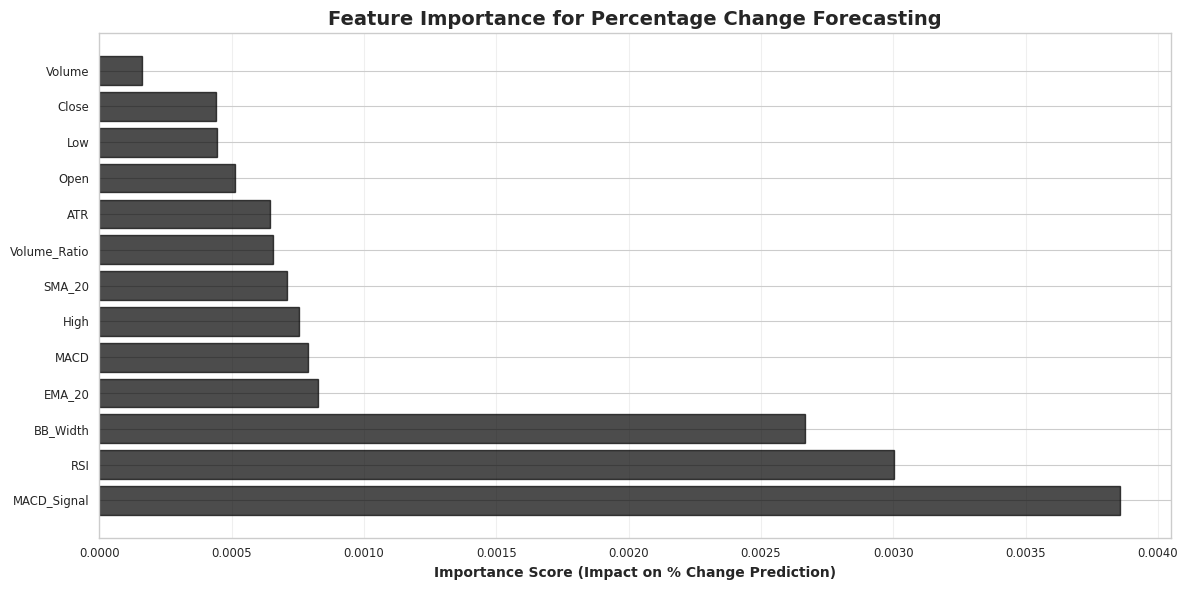

In [19]:
print("Analyzing which features most impact percentage change predictions...\n")

feature_importance = []
baseline_pred = onnx_session.predict(X_test[:100])

for i, feature in enumerate(feature_cols):
    X_test_perturbed = X_test[:100].copy()
    X_test_perturbed[:, :, i] = np.random.permutation(X_test_perturbed[:, :, i])
    perturbed_pred = onnx_session.predict(X_test_perturbed)

    importance = np.mean(np.abs(baseline_pred - perturbed_pred))
    feature_importance.append((feature, importance))

feature_importance.sort(key=lambda x: x[1], reverse=True)

print("Feature Importance for Percentage Change Prediction:")
print("-" * 60)
for rank, (feature, importance) in enumerate(feature_importance, 1):
    print(f"{rank:2d}. {feature:20s}: {importance:.6f}")

fig, ax = plt.subplots(figsize=(12, 6))
features, importances = zip(*feature_importance)
ax.barh(features, importances, alpha=0.7, edgecolor='black')
ax.set_xlabel('Importance Score (Impact on % Change Prediction)')
ax.set_title('Feature Importance for Percentage Change Forecasting', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

---

## Cell 22: Forecast Report

In [20]:
report_df = create_forecast_report(
    y_true=y_test_unscaled,
    y_pred=onnx_predictions_unscaled,
    model_name='LSTM + ONNX'
)

print("\n" + "=" * 60)
print("Forecast Performance Report")
print("=" * 60)
print(report_df.to_string(index=False))
print("=" * 60)


Forecast Performance Report
      Model    MAE   RMSE  MAPE     R² Direction Acc
LSTM + ONNX 7.0812 9.6924 0.74% 0.9383        47.14%
